In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from scipy import stats
from matplotlib import font_manager, rc
from sklearn.preprocessing import OneHotEncoder
import warnings
from scipy.stats import norm

## Modeling Rent with Linear Regression
> This section applies a **linear regression model** to quantify how key apartment characteristics—such as size, age, floor level, and layout—relate to monthly rent in Tokyo. Model performance and coefficient interpretation are used to assess both predictive accuracy and the relative importance of each feature.

In [15]:
# Load Tokyo housing metrics table to DataFrame
tokyo_housing_df = pd.read_csv('tokyo_housing.csv', header = 0)

### Adjust Floor Values
> When expanding the `floor` ranges (e.g., `B1-2`) the resulting dataset included `0` values, which is practically meaningless and should therefore be interpreted as the ground floor, or `1`, for the purposes of this analysis. 

In [21]:
# Fix invalid floor values (0 → 1)
tokyo_housing_df['floor'] = (
    np.where(
        tokyo_housing_df['floor'] == 0, 1, tokyo_housing_df['floor']
    )
)

### Data Preprocessing & One-Hot Encoding 
>- The target variable (`rent`) is separated from the predictors.
>- The data is split into **training and testing sets**.
>- The categorical variable `floor_plan` is encoded using **OneHotEncoder** with `drop='first'` to **avoid multicollinearity**.
>- **Encoded columns are combined with the numeric features** (`area`, `building_age`, `building_size`, `floor`) to form the **final feature matrices** for training and testing.

In [23]:
# Define X, y for LinearRegression
X = tokyo_housing_df.drop(columns = ['rent'])
y = tokyo_housing_df['rent']

# Split data into training & testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Initialize OneHotEncoder for categorical variables (floor_plan)
# sparse_output returns a numpy array, which is easier to inspect & convert back to DataFrame
encoder = OneHotEncoder(drop = 'first', handle_unknown = 'ignore', sparse_output = False)

# OneHotEncoder may throw a UserWarning error from 'unknown categories' -- these will be encoded as zeros
warnings.filterwarnings('ignore', category = UserWarning)

# Pass DataFrame to the encoder to preserve the column name
X_train_enc = encoder.fit_transform(X_train[['floor_plan']])
X_test_enc = encoder.transform(X_test[['floor_plan']])

# Get the encoded feature names to for columns in the DataFrame
encoded_cols = list(encoder.get_feature_names_out(['floor_plan']))
print(f'Encoded categories: {encoder.categories_}')

# Use the index = X_train.index parameter to ensure that the indexing matches 
X_train_enc = pd.DataFrame(X_train_enc, columns = encoded_cols, index = X_train.index)
X_test_enc = pd.DataFrame(X_test_enc, columns = encoded_cols, index = X_test.index)

# Final train/test sets include area and floor_plan encoded features
X_train = pd.concat([X_train[['area', 'building_age', 'building_size', 'floor']], X_train_enc], axis = 1)
X_test = pd.concat([X_test[['area', 'building_age', 'building_size', 'floor']], X_test_enc], axis = 1)

Encoded categories: [array(['1DK', '1K', '1LDK', '1LK', '1R', '1SDK', '1SK', '1SLDK', '2DK',
       '2K', '2LDK', '2SDK', '2SK', '2SLDK', '3DK', '3K', '3LDK', '3SLDK',
       '4DK', '4K', '4LDK'], dtype=object)]


### Simple Linear Regression Using Area Only
>- We fit a **simple linear regression model** using only `area` to predict `rent`.
>- This serves as a **baseline model**, since `area` shows the **strongest linear relationship** with `rent` by a wide margin.
>- We evaluate performance using **5-fold cross-validation**, providing a benchmark for the predictive power of the single-feature model.
>- On average, the **model explains about 77.9% of the variance** ($R^2$) in `rent` across the 5-fold splits.

In [24]:
# Initialize model 
lr0 = LinearRegression()

# Simple Linear Regression
X_train_0 = X_train[['area']]

# Compute scores for 5-fold cross validation on training dataset
score_0 = cross_val_score(lr0, X_train_0, y_train, cv = 5).mean()
print(f'The average of the R-squared values is {score_0: .3f}')

The average of the R-squared values is  0.779


### Multiple Linear Regression Model
>- We expand to a full **multivariate model** using all available numeric and encoded features.
>- Before fitting, we standardize the predictors with **StandardScaler** to ensure that **all variables are on comparable scales**.
>- **Cross-validation** again provides an estimate of the **model’s general performance**.
>- Averaged over the 5-fold splits, the **model achieves an $R^2$ of about 88.9%** for `rent`, significantly outperforming the single-feature model.

In [25]:
# Initialize model                            
lr1 = LinearRegression()

# Initialize scaler object & standardize data for regression
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# Multiple Linear Regression
score_1 = cross_val_score(lr1, X_train_scaled, y_train, cv = 5).mean()
print(f'The average of the R-squared values is {score_1: .3f}')

The average of the R-squared values is  0.889


### Model Fitting & Performance Evaluation
>- We train a **LinearRegression** model on the scaled training data and **generate predictions for both training and testing sets**.
>- Performance is evaluated using **R-squared**, allowing us to compare model fit on seen vs. unseen data and **check for overfitting**.
>- The model attains an **$R^2$** of approximately **89.3% on the training set** and about **88.0% on the testing set**.
>- In other words, the **model explains about 88.0% of the variance** in `rent` on **unseen data**.

In [26]:
# Initialize Linear Regression model & fit to the training data
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Make predictions on training and testing sets
y_train_pred = lr.predict(X_train_scaled)
y_test_pred = lr.predict(X_test_scaled)

# Evaluate on training set
r2_train = r2_score(y_train, y_train_pred)
print(f'R-squared value the training set: {r2_train: .3f}')

# Evaluate on testing set
r2_test = r2_score(y_test, y_test_pred)
print(f'R-squared value on the testing set: {r2_test: .3f}')

R-squared value the training set:  0.893
R-squared value on the testing set:  0.880


In [27]:
# ---------------------------------------
# Model Coefficient Summary
# ---------------------------------------
# Coefficients are from a linear regression fit on standardized features.
# For numeric features, dividing the coefficient by feature_std yields an
# approximate per-unit effect on rent. Categorical features should be
# interpreted relative to the reference category and not unit-adjusted.
# ---------------------------------------

coef_table = (
    pd.DataFrame({
        'feature': X_train.columns,
        'coefficient': lr.coef_
    })
    .assign(
        feature_std = lambda df: df['feature'].apply(
            lambda feat: X_train[feat].std()
        )
    )
)

# Save table to CSV file
coef_table.to_csv('coef_table.csv', index = False)
coef_table

,feature,coefficient,feature_std
0,area,39955.025026,16.781754
1,building_age,-16628.000325,16.561668
2,building_size,8826.464115,3.736979
3,floor,2750.716858,2.502783
4,floor_plan_1K,-3930.000847,0.477528
5,floor_plan_1LDK,4612.813067,0.373623
6,floor_plan_1LK,-532.192296,0.016186
7,floor_plan_1R,-2775.848540,0.413280
8,floor_plan_1SDK,580.266840,0.022887
9,floor_plan_1SK,-611.993677,0.042790


### Residual Analysis & Diagnostics
>In this section, a **histogram and KDE plot** are used to visualize the residuals—the **differences between predicted and actual** `rent` values on the **testing set**. This helps identify **nonlinearity**, **heteroscedasticity**, or **other patterns** the linear model may not be capturing.

In [28]:
# Create a residual dataset from test-set predictions for diagnostic analysis
model_residuals = pd.DataFrame({
    'actual': y_test,
    'predicted': y_test_pred,
    'residual': y_test_pred - y_test
    }
)

# Export to CSV file for downstream visualization or validation.
model_residuals.to_csv('model_residuals.csv', index = False)

In [ ]:
# Initialize fig, ax
fig, ax = plt.subplots(figsize = (15, 8))

# Scatter plot for residuals
sns.histplot(data = model_residuals, x = 'residual', palette = palette[0], kde = True, stat = 'density')

# Set title, axis labels
ax.set_title('Distribution of Residuals', fontsize = 18, fontweight = 'bold')
ax.set_xlabel('Residuals (Predicted - Actual)', fontsize = 12)
ax.set_ylabel('Density', fontsize = 12)

plt.savefig('residuals.png')

> **Residual Plot of Predicted vs. Actual Values**
>- The histogram is **centered around zero**, suggesting a lack of systematic bias in the model. Furthermore, it appears to have a mostly **symmetric, bell-shaped curve** which implies that the residuals are normally distributed. 
>- Although the concentration of outliers appears quite small, there are some **extreme values** along the plot that suggest points where the model performs poorly. This may be due to **higher variability in rental prices for outlier feature values** (e.g., very large `area`, `building_size`, or `floor_plan`).
>- **Since the housing budget is capped, the removal of extreme rental values may not only improve model performance but also align better with the allotted price range.** 

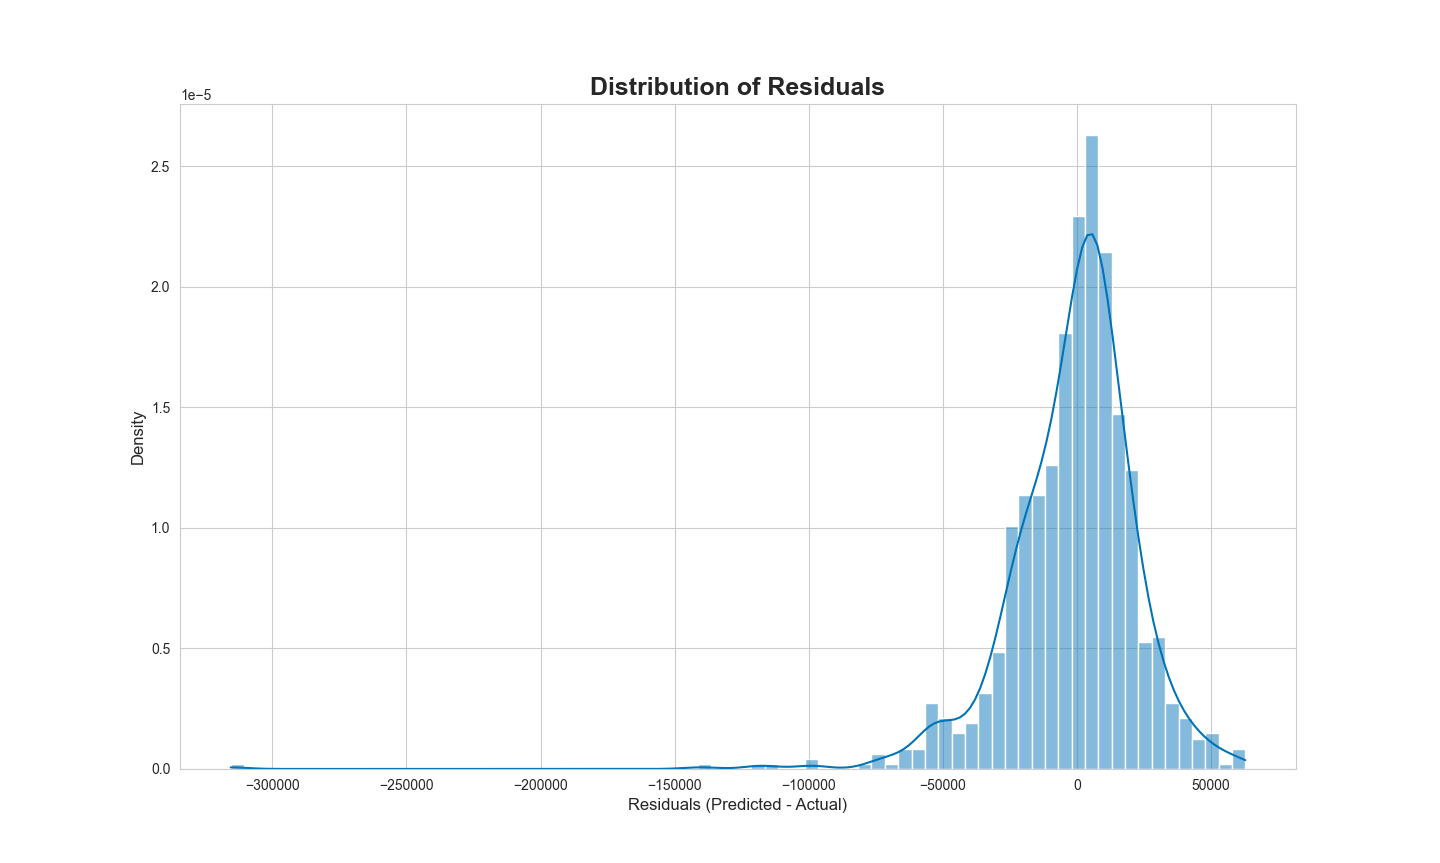